# Lesson 2: Convolutional Neural Networks with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

In [1]:
import os
import sys
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

# get matplotlib configuration
%matplotlib inline
%run plot_conf.py

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import (
    Variable,
)

from torch.nn import (
    init,
)

from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

### Convolutional Neural Networks (CNN)

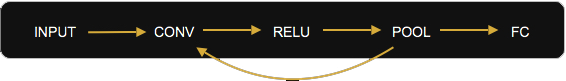

In [3]:
Image(filename='figures/ch03_cnn_pipeline-k.png') 

### Simple CNN for MNIST Classification

In [4]:
# training params
batch_size = 64
num_epochs = 3
learning_rate = 0.01
dropout_p = 0.5
log_interval = 1 # epochs
num_hidden_units = 50
num_classes = 10 # MNIST
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = True
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 1234
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [5]:
# Train data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

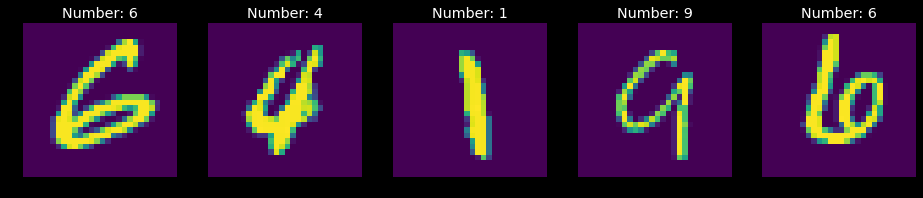

In [6]:
# Visualize some samples
batch = next(iter(test_loader))  # test_loader is an iterable
samples = batch[0][:5]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title('Number: %i' % y_true[i])
    plt.imshow(sample.numpy().reshape((28,28)))
    plt.axis('off')

In [13]:
# CNN model
class CNN(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        # super(CNN, self).__init__()  # for Python 2
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout_conv2 = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(320, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x):
        """
        Feed Foward.
        """
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout_conv2(self.conv2(x)), 2))
        x = x.view(-1, 320)  # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x  # logits

In [14]:
# Initialize model components
model = CNN(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
def process_batch(inputs, targets, model, criterion, optimizer, cuda, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    if cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, volatile=True, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [16]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda):
    """
    Training.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(inputs))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(inputs))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                

            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_interval == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
    
    return model

In [17]:
model = train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

TIME REMAINING: 1m 53s
[EPOCH]: 0, [TRAIN LOSS]: 0.018932, [TRAIN ACC]: 0.580, [TEST LOSS]: 0.005292, [TEST ACC]: 0.923
TIME REMAINING: 0m 49s
[EPOCH]: 1, [TRAIN LOSS]: 0.015572, [TRAIN ACC]: 0.666, [TEST LOSS]: 0.003715, [TEST ACC]: 0.929
TIME REMAINING: 0m 0s
[EPOCH]: 2, [TRAIN LOSS]: 0.010532, [TRAIN ACC]: 0.789, [TEST LOSS]: 0.002620, [TEST ACC]: 0.952


In [29]:
def infer(model, inputs):
    """
    Inference.
    """
    if cuda:
        inputs = inputs.cuda()

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(inputs, volatile=True, requires_grad=False)

    # Forward pass
    scores = model(X_batch)  # logits

    # Accuracy
    score, predicted = torch.max(scores, 1)

    return predicted

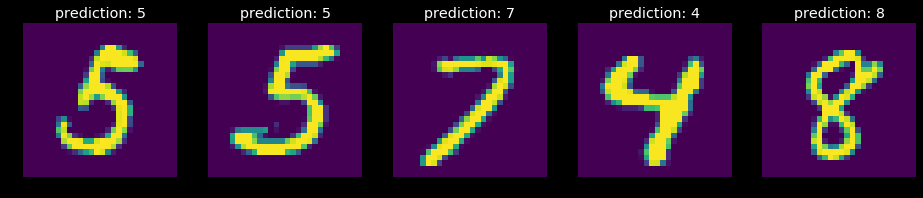

In [30]:
# Visualize some predictions
batch = next(iter(test_loader))
samples = batch[0][:5]
y_preds = infer(model, samples)
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title('prediction: %i'% y_preds[i].data[0])
    plt.imshow(sample.numpy().reshape((28,28)))
    plt.axis('off')

### Torchvision Datasets and Models

- Using popular model architectures.

#### Datasets

In [31]:
# Train data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

In [32]:
# Classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

In [33]:
def toimage(myTensor):
    return myTensor.numpy().transpose((1, 2, 0))

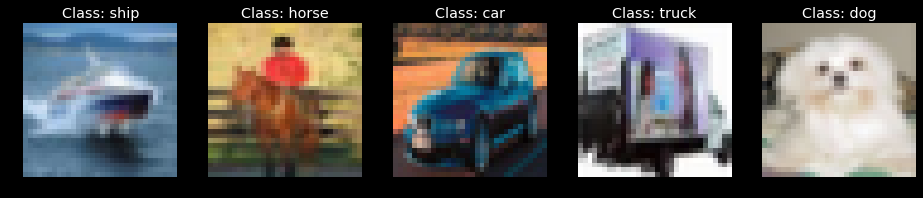

In [34]:
# Visualize some samples
batch = next(iter(test_loader))
samples = batch[0][:5]
y_true = batch[1]
plt.subplot(1, 5, 1)
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title('Class: %s'% classes[y_true[i]])
    plt.imshow(toimage(sample))
    plt.axis('off')

#### Models

In [18]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print (model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [19]:
data_dir = 'data'
model_name = 'resnet18'
num_workers = 4
num_epochs = 10
batch_size = 256
learning_rate = 1e-1
momentum = 0.9
weight_decay = 1e-4
log_every = 10

In [20]:
model = models.__dict__[model_name](pretrained=True) # Set false to train from scratch
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay,
                     )
print (model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/GokuMohandas/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:05<00:00, 8479464.21it/s]


ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

- Find more models architectures and models for specific datasets at https://github.com/pytorch/vision/tree/master/torchvision

### Transfer Learning

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

### CNNs for Text Classification

**TAKEAWAY**: Convolutional Layers can be used a basic building blocks in many other types of networks.

Our inputs will be 2D, where each row holds the representation for each word or character. The filters for text input will also be 2D where the width of the filters are the same width (representation dimension) as the input. The height of the filters represents the sliding window length for the text and it is common to apply filters of varying sizes. The filters convolve on the input and produce our features maps.

In figure XXXX, we are using three different filter shapes on the input text. Once we apply the filters and receive our feature maps, we apply pooling to keep the most relevant information. We concat the pooling results from all of our filters and feed into an FC layer to receive our class scores. Also note that we use words as our text inputs, but we can also use character level inputs as they hold valuable morphological information. Applying filters on characters is analogous to learning n-grams where the width of the filter corresponds to the n. Using characters also allows us to account for out of vocabulary (OOV) inputs such as new words or mispellings. For example, "I love this restaurant" and "I loooove this restaurant" should both hold similar representations since they mean the same thing. Using character level convolutions will allow us to account for the difference and recive similar representations.

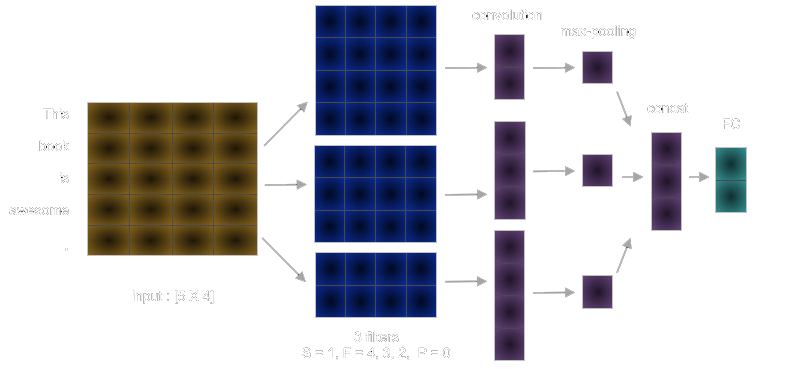

In [47]:
Image(filename='figures/ch03_cnn_nlp-k.png') 

In our figure above, we use just one convolutional operation but we can choose to use more as this will increase the receptive fields of the subsequent layers. We want this feature in text processing because we want to map local relationships to see how they affect the context of the entire input span.

One way to increase the receptive fields is to add more layers. Adding more layers allows the later layers to learn high level abstractions over our input data. As we add more layers, our view on the entire input becomes greater. Adding more layers, does however, have a few issues surrounding error signal propagation back through our network. This topic will be covered in chapter 4 along with other gradient related issues and potential solutions to counter them.

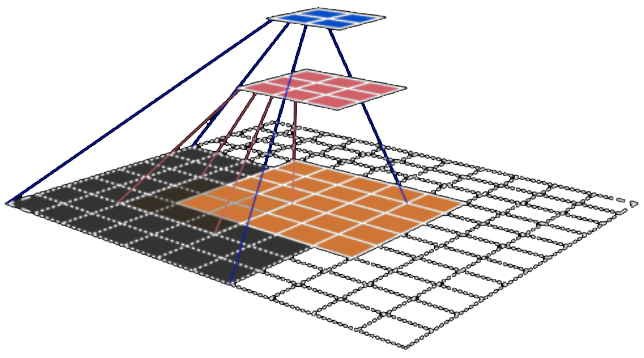

In [48]:
Image(filename='figures/receptive-k.png') 

#### Advantages of using convolutions

When we apply our convolutional filters, the operations are completely independent. Each layer's operations can happen in parallel which gives us computational speed and efficiency. With GPUs, we can really take advantage of this parallelism for very large networks with many filters.

Convolution also allows us to view the entire input simultaneously through the benefits of increased receptive fields. This is very useful for text processing where the overall representation can drastically be altered with just one or a few additional inputs. For examples the sentiment change between "I really like this" and "I really don't like this". 

### Example: Document Classification with Convolutional Neural Networks

This example will focus on using CNNs for document classification. We will attempt to read some documents (ex. news titles) and the goal is to predict which classification (ex. news section) it belongs to.

#### data.py

One of the key distinctions in this example is how we present our data. Instead of using the bag or words approach, we will be using the one-hot vector representation. If we were to represent each word in a one-hot vector fashion we would have a vector of zeros except at one particular index. This is a very dense way of representing our data since the vectors will be as long a the number of words in our corpus but only of the values will non-zero. Instead, we will be applying one-hot vectorization but at a character level. We will represent each input as a sequence of individual characters. Including spaces, we have a total of 32 unique characters.

```bash
Processed input:
 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ...,
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
Processed output: 1
```

#### utils.py

We will have an unknown token, in the event that we encounter a foreign character during inference. We also have an additional padding (`PAD`) token which we use for padding our inputs. We need to pad our inputs in a batch so that we can process them efficiently at once with convolution. Traditionally, when using CNNs with images, the input data are all uniformly shaped (ex. 3D images). However, with our text inputs, we can have arbitrarily long inputs. We apply padding prior to feeding into the model because that is the moment we need the input to be uniformly shaped. 

```python
PAD_ID = 0
UNK_ID = 1

...

def pad(inputs, char2index, max_length=None):
    """
    Pad the inputs.
    """

    # If not max_len, assume first input
    # is largest (inputs already sorted by size)
    if max_length is None:
        max_length = len(inputs[0])

    # Pad the inputs
    lengths = []
    padded_inputs = []
    for item in inputs:
        lengths.append(len(item))

        # Create padding
        padding = np.zeros((max_length-len(item), len(char2index)))
        for i, row in enumerate(padding):
            padding[i][char2index["__PAD__"]] = 1.

        # Add padding to current input
        padded_input = np.vstack((item, padding))

        # Add to padded inputs
        padded_inputs.append(padded_input)

    return padded_inputs, lengths
```

#### model.py

The model uses convolutional layers, pooling followed by fully connected layers to output out logit scores. The first step is to initialize the convolutional filters with `nn.Conv2d`. This module takes in the number of input channels (one in our case since our input is one dimensional character representations), the number of output channels (the number of filters {K} we want of that filter size), the filter size it self which has dimensions (filter size, num_channels), stride length, padding and if we want to include a bias term. Recall that the number of channels of the filter has to match with the dimensions of the inputs, which is 32 in our case (32 unique characters). We also initialize our dropout and the fully connected layer which will take the outputs from the convolution and max-pooling and convert to logit scores for each class. Also note that the pooling operations do not have weights since they are just downsampling operations which reduce the spatial size of the representation. And lastly, we make a call to properly initialize our filters.

```python
def __init__(self, num_channels, num_filters, num_classes,
    dropout_p):
    """
    Initialize weights.
    """
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=num_filters,
        kernel_size=(2, num_channels),
        stride=1,
        padding=0,
        bias=True,
        )
    ...
    
    self.dropout = nn.Dropout(dropout_p)
    self.fc1 = nn.Linear(3*num_filters, num_classes)

    # Initialize weights
    self.init_weights()
```

We properly initialize our filter weights using xavier initialization and we also initialize our filter biases with a constant. 

```python
def init_weights(self):
    """
    Initialize weights.
    """
    for conv in [self.conv1, self.conv2, self.conv3]:
        init.xavier_uniform(conv.weight, gain=1)
        init.constant(conv.bias, 0.1)
```

The forward pass beings with convering our batch from 3D to 4D, which comprises of the number of samples, followed by the added dimension, then the number of characters in the particular input, and the dimension of each character (32). The number of words is the same for each sample since we apply padding earlier. We apply our filters onto the input independently of each filter. We have three unique filters, so the output of processing the input with each filter is `[num-of-unique-filters X [N, num_kernels, #words]]`. Next, we apply max-pooling on the input where the `kernel_size` is the number of filters from the convolutional layer. This means that we will receive just one max value from each unique conv. We end up with a result of dimensions `[num-of-unique-filters X [N, num_kernels]]`. We can then go ahead and concatenate the results which have dimensions `[N, len(filter_lengths)*num_kernels]`. We feed this into our fully connected layer which presents us with logit scores for each class.

```python
def forward(self, x):
    """
    Forward pass.
    """

    # Make each input 3D to apply filters
    x = x.unsqueeze(1) # (N, 1, W, D)

    # Apply convolution and pooling
    convs = [self.conv1, self.conv2, self.conv3]
    x = [F.relu(conv(x)).squeeze(3) for conv in convs] # num-of-unique-filters X [N, num_kernels, #words]
    x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # num-of-unique-filters X [N, num_kernels]

    # Concat activations
    x = torch.cat(x, 1) # [N, len(filter_lengths)*num_kernels]

    # Dropout
    x = self.dropout(x)

    # FC layer
    logits = self.fc1(x)

    return logits
```

### End